In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
#transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#trainset into 80% training and 20% validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

#define batch_size
batch_size = 256

# data loaders for train validate and test
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

#define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

# load vgg16
vgg16 = models.vgg16_bn(pretrained=True)  # load vgg16
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)

# load resnet18
resnet18 = models.resnet18(pretrained=True)  # ResNet18
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

# load alexnet
alexnet = models.alexnet(pretrained=True)  # Load AlexNet
alexnet.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Adjust for 32x32 input
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, num_classes)

#put them as dictionary
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    "AlexNet": alexnet
}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in 

In [6]:
#train the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, trainloader, valloader, num_epochs=5, lr=0.001):
    cost = nn.CrossEntropyLoss() #use cross entropy as loss function
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #as optimizer using sgd
    start_time = time.time() #start time for calculate the time of the model to train

    model = model.to(device)  # Move model to GPU

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # models training model

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()  #zgradients as zero
            outputs = model(inputs)  #forward pass
            loss = cost(outputs, labels)  #compute the loss
            loss.backward()  # backward pass
            optimizer.step()  # update the weights

            running_loss += loss.item() #all the loss here

        # validaton through iterations(epochs)
        val_accuracy = evaluate_model(model, valloader)
        print(f"epoch [{epoch+1}/{num_epochs}], loss: {running_loss/len(trainloader):.4f}, validation accuracy: {val_accuracy:.2f}%")

    training_time = time.time() - start_time #finish calculate time of model training
    return training_time


In [7]:
#evaluate the models
def evaluate_model(model, dataloader):
    model.eval()  # model evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader: #iterate through dataloaders
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) #calculate the total tp in these lines
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# calculate model size by parameters
def calculate_model_size_in_memory(model):
    total_params = sum(param.numel() for param in model.parameters())
    return total_params

#cross-validation function
def cross_validate(model_class, model_name, trainset, num_folds=5, num_epochs=5):
    kf = KFold(n_splits=num_folds, shuffle=True)
    #store teh accuracy time and model size in lists
    accuracies = []
    training_times = []
    model_sizes = []

    print(f"\n=== Cross-Validation for {model_name} ===")

    #iterate through
    for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
        print(f"\nFold {fold + 1}/{num_folds}")

        # data loaders for train and validaton dataseets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        fold_trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
        fold_valloader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)

        # Initialize a new model instance for each fold
        model = model_class.to(device)  # Move model to GPU

        # Train the model
        training_time = train_model(model, fold_trainloader, fold_valloader, num_epochs=num_epochs)

        # Evaluate model on the validation set
        accuracy = evaluate_model(model, fold_valloader)
        model_size = calculate_model_size_in_memory(model)

        #put the result to their corresponding lists
        accuracies.append(accuracy)
        training_times.append(training_time)
        model_sizes.append(model_size)

        print(f"Fold {fold + 1}: Accuracy = {accuracy:.2f}%, Time = {training_time:.2f} sec, Total Parameters: {model_size}")

    # calculate teh average of accuracy time and mode size
    avg_accuracy = sum(accuracies) / num_folds
    avg_time = sum(training_times) / num_folds
    avg_size = sum(model_sizes) / num_folds

    # print ht results
    print(f"\nAverage Accuracy for {model_name}: {avg_accuracy:.2f}%")
    print(f"Average Training Time: {avg_time:.2f} sec")
    print(f"Average Model Size (Total Parameters): {avg_size}")

    return avg_accuracy, avg_time, avg_size

In [8]:
# validate alexnet
print("\n=== Cross-Validation for AlexNet ===")
alexnet_model = models_dict['AlexNet']  # get alexnet model from the dictionary
avg_acc_alexnet, avg_time_alexnet, avg_size_alexnet = cross_validate(alexnet_model, "AlexNet", train_subset, num_folds=5, num_epochs=5)

print(f"\nAlexNet - Average Accuracy: {avg_acc_alexnet:.2f}%, Average Time: {avg_time_alexnet:.2f} sec, Model Size: {avg_size_alexnet}")

#validate resnet18
print("\n=== Cross-Validation for ResNet18 ===")
resnet18_model = models_dict['ResNet18']  #get ResNet18 model from the dictionary
avg_acc_resnet18, avg_time_resnet18, avg_size_resnet18 = cross_validate(resnet18_model, "ResNet18", train_subset, num_folds=5, num_epochs=5)

print(f"\nResNet18 - Average Accuracy: {avg_acc_resnet18:.2f}%, Average Time: {avg_time_resnet18:.2f} sec, Model Size: {avg_size_resnet18}")
# validae vgg16
print("\n=== Cross-Validation for VGG16 ===")
vgg16_model = models_dict['VGG16']  # get VGG16 model from the dictionary
avg_acc_vgg16, avg_time_vgg16, avg_size_vgg16 = cross_validate(vgg16_model, "VGG16", train_subset, num_folds=5, num_epochs=5)

print(f"\nVGG16 - Average Accuracy: {avg_acc_vgg16:.2f}%, Average Time: {avg_time_vgg16:.2f} sec, Model Size: {avg_size_vgg16}")



=== Cross-Validation for AlexNet ===

=== Cross-Validation for AlexNet ===

Fold 1/5
epoch [1/5], loss: 1.8610, validation accuracy: 41.45%
epoch [2/5], loss: 1.5271, validation accuracy: 48.71%
epoch [3/5], loss: 1.4020, validation accuracy: 51.75%
epoch [4/5], loss: 1.3006, validation accuracy: 55.98%
epoch [5/5], loss: 1.2249, validation accuracy: 57.98%
Fold 1: Accuracy = 57.98%, Time = 61.42 sec, Total Parameters: 57023306

Fold 2/5
epoch [1/5], loss: 1.1902, validation accuracy: 60.85%
epoch [2/5], loss: 1.1386, validation accuracy: 62.26%
epoch [3/5], loss: 1.0822, validation accuracy: 62.85%
epoch [4/5], loss: 1.0401, validation accuracy: 64.86%
epoch [5/5], loss: 1.0037, validation accuracy: 65.85%
Fold 2: Accuracy = 65.85%, Time = 59.84 sec, Total Parameters: 57023306

Fold 3/5
epoch [1/5], loss: 0.9683, validation accuracy: 68.60%
epoch [2/5], loss: 0.9342, validation accuracy: 68.92%
epoch [3/5], loss: 0.8973, validation accuracy: 69.95%
epoch [4/5], loss: 0.8718, validati

In [9]:
# see the best model
best_model = max(models_dict, key=lambda name: evaluate_model(models_dict[name], valloader))
print(f"\nBest Model: {best_model}")


# eval the best model on the test dataset
test_accuracy = evaluate_model(models_dict[best_model], testloader)
print(f"Test Accuracy for Best Model ({best_model}): {test_accuracy:.2f}%")



Best Model: VGG16
Test Accuracy for Best Model (VGG16): 83.55%


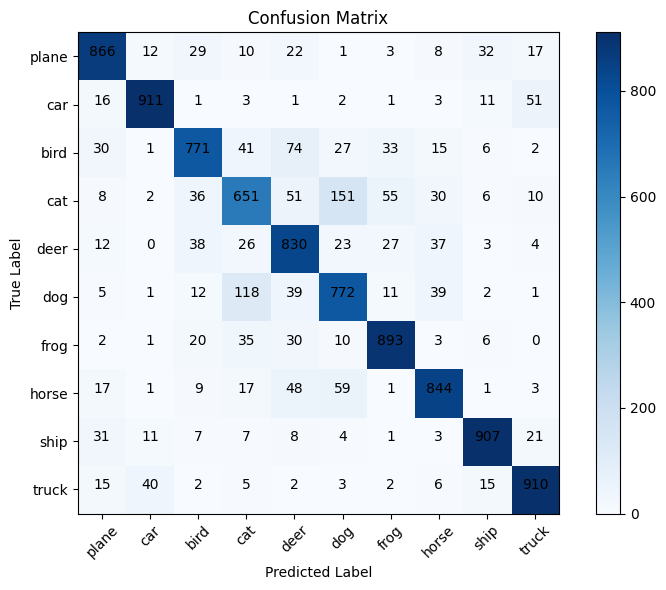

In [10]:
# get the best model object for matrix
best_model_obj = models_dict[best_model].to(device)  # move the modeel to device for google colab

# display the confusion matrix for the best model
def plot_confusion_matrix(model, dataloader):
    model.eval()  # model evaluation mode
    all_preds = []  # pred list
    all_labels = []  # true label list

    # get prediction and labels
    with torch.no_grad():
        for inputs, labels in dataloader:  # iterate through dataloader
            inputs = inputs.to(device)  # move the inputs to the device for google colab needed it
            labels = labels.to(device)  # move the label to device for google colab

            outputs = model(inputs)  # forward pass
            _, preds = torch.max(outputs, 1)  # get predicted class

            all_preds.extend(preds.cpu().numpy())  # add pred to list
            all_labels.extend(labels.cpu().numpy())  # add labels to the list

    # compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()

    # add class labels to the axes
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # add text inside the confusion matrix boxes
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', color='black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# plot confusion matrix for the best model
plot_confusion_matrix(best_model_obj, testloader)


In [11]:
import copy

# Test different batch sizes
def test_batch_size(model, trainset, batch_sizes=[256, 512, 1024], num_epochs=5):
    for batch_size in batch_sizes:
        print(f"\nTesting Batch Size: {batch_size}")

        # Create new dataloaders with the specified batch size
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Copy model for experiment
        model_copy = copy.deepcopy(model).to(device)
        training_time = train_model(model_copy, trainloader, valloader, num_epochs=num_epochs)
        val_accuracy = evaluate_model(model_copy, valloader)

        # Evaluate on test set
        test_accuracy = evaluate_model(model_copy, testloader)

        # print batch size val accuracy test accurcy and time
        print(f"Batch Size: {batch_size}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Training Time: {training_time:.2f} sec")

# different input sample sizes
def test_input_sample_size(model, trainset, sample_proportions=[0.5, 0.8, 1.0], num_epochs=3):
    for proportion in sample_proportions:
        train_size = int(proportion * len(trainset))
        val_size = len(trainset) - train_size

        # ensure at least one sample in the validation set
        if val_size == 0:
            val_size = 1
            train_size = len(trainset) - 1

        # Split the dataset for new proportion
        train_subset, val_subset = random_split(trainset, [train_size, val_size])
        # loaders
        trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=32, shuffle=False)

        print(f"\nTesting Input Sample Size: {int(proportion * 100)}% of the dataset")
        # train the model
        model_copy = copy.deepcopy(model).to(device)
        training_time = train_model(model_copy, trainloader, valloader, num_epochs=num_epochs)
        val_accuracy = evaluate_model(model_copy, valloader)

        # eval on test set
        test_accuracy = evaluate_model(model_copy, testloader)

        print(f"Input Size: {int(proportion * 100)}%, Val Accuracy: {val_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Train Time: {training_time:.2f} sec")

# test the epoch count
def test_training_duration(model, trainloader, valloader, epoch_counts=[3, 5, 7]):
    for num_epochs in epoch_counts:
        print(f"\nTesting Training Duration: {num_epochs} Epochs")

        #copy the model
        model_copy = copy.deepcopy(model).to(device)
        training_time = train_model(model_copy, trainloader, valloader, num_epochs=num_epochs)
        val_accuracy = evaluate_model(model_copy, valloader)

        #evaluate on test
        test_accuracy = evaluate_model(model_copy, testloader)

        # Pprint hte epcoh val accuracy test and train time
        print(f"Epoch: {num_epochs}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Train Time: {training_time:.2f} sec")


In [12]:
# Assuming best_model, trainset, and val_subset are already defined
best_model_obj = models_dict[best_model].to(device)
print("\nStarting Experiments\n")

# Test different batch sizes
test_batch_size(best_model_obj, trainset, batch_sizes=[256, 512, 1024], num_epochs=5)

# Test different input sample sizes
test_input_sample_size(best_model_obj, trainset, sample_proportions=[0.5, 0.8, 1.0], num_epochs=3)

# Test different training durations (number of epochs)
test_training_duration(best_model_obj, trainloader, valloader, epoch_counts=[3, 8, 12])



Starting Experiments...


Testing Batch Size: 256
epoch [1/5], loss: 0.1842, validation accuracy: 95.27%
epoch [2/5], loss: 0.0575, validation accuracy: 98.52%
epoch [3/5], loss: 0.0272, validation accuracy: 99.57%
epoch [4/5], loss: 0.0158, validation accuracy: 99.87%
epoch [5/5], loss: 0.0112, validation accuracy: 99.94%
Batch Size: 256, Val Accuracy: 99.94%, Test Accuracy: 84.50%, Training Time: 106.73 sec

Testing Batch Size: 512
epoch [1/5], loss: 0.1841, validation accuracy: 93.59%
epoch [2/5], loss: 0.0618, validation accuracy: 97.46%
epoch [3/5], loss: 0.0334, validation accuracy: 98.87%
epoch [4/5], loss: 0.0212, validation accuracy: 99.41%
epoch [5/5], loss: 0.0139, validation accuracy: 99.76%
Batch Size: 512, Val Accuracy: 99.76%, Test Accuracy: 84.20%, Training Time: 102.03 sec

Testing Batch Size: 1024
epoch [1/5], loss: 0.1915, validation accuracy: 90.46%
epoch [2/5], loss: 0.0901, validation accuracy: 94.63%
epoch [3/5], loss: 0.0521, validation accuracy: 96.97%
epoch [